In [3]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten, Concatenate, TimeDistributed, Bidirectional   
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import optuna
import os
import tensorflow as tf
from tensorflow.keras.layers import PReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D


# Funciones
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None



def calculate_fourier_features(series, n_components=5):
    fft = np.fft.fft(series)
    fft_magnitudes = np.abs(fft)[:len(fft) // 2]  # Usar solo frecuencias positivas
    top_frequencies = np.argsort(fft_magnitudes)[-n_components:]  # Seleccionar las más importantes
    top_magnitudes = fft_magnitudes[top_frequencies]
    
    # Asegurarse de que `top_magnitudes` siempre tenga longitud `n_components`
    if len(top_magnitudes) < n_components:
        # Si hay menos componentes, rellenar con ceros
        padding = np.zeros(n_components - len(top_magnitudes))
        top_magnitudes = np.concatenate([top_magnitudes, padding])
    
    return top_magnitudes


def load_images_and_ghi(df_filtrado, image_folder, n_fourier=5):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []
    hour_sin = []
    hour_cos = []
    fourier_features = []

    # Inicializar la última imagen válida con una imagen de ceros por si es la primera vez
    last_valid_image = np.zeros((64, 64, 3), dtype=np.uint8)

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']

        # Calcular seno y coseno de la hora del día
        hour_fraction = timestamp.hour + timestamp.minute / 60.0
        hour_sin_value = np.sin(2 * np.pi * hour_fraction / 24)
        hour_cos_value = np.cos(2 * np.pi * hour_fraction / 24)

        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path)

        if img is not None:
            # Procesar la imagen si está disponible
            img_resized = cv2.resize(img, (64, 64))
            img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_resized)
            last_valid_image = img_preprocessed  # Actualizar la última imagen válida
        else:
            # Usar la última imagen válida (Forward Fill)
            img_preprocessed = last_valid_image
            print(f"Imagen no encontrada: {image_path}, usando la última imagen válida.")

        # Agregar valores a las listas
        images.append(img_preprocessed)
        ghi_values.append(ghi_value)
        doy_sin.append(doy_sin_value)
        doy_cos.append(doy_cos_value)
        hour_sin.append(hour_sin_value)
        hour_cos.append(hour_cos_value)

        # Calcular componentes de Fourier para GHI
        if len(ghi_values) >= n_fourier:
            fourier_comp = calculate_fourier_features(ghi_values[-n_fourier:], n_components=n_fourier)
        else:
            fourier_comp = np.zeros(n_fourier)  # Rellenar con ceros si no hay suficientes datos

        fourier_features.append(fourier_comp)

    # Convertir a numpy arrays, asegurando consistencia en las dimensiones
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    hour_sin = np.array(hour_sin).reshape(-1, 1)
    hour_cos = np.array(hour_cos).reshape(-1, 1)

    # Convertir fourier_features en numpy array de forma consistente
    fourier_features = np.array(fourier_features)

    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos, hour_sin, hour_cos, fourier_features


# Preparar secuencias para la LSTM
def create_sequences(images, aux_features, ghi_values, time_steps, n_steps=12):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps - n_steps + 1):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es una secuencia de `n_steps` valores GHI después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps:i + time_steps + n_steps].flatten())

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)


# Cargar datos y preparar el conjunto de entrenamiento
df = pd.read_pickle('/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/df_GHI.plk')

# Filtrar datos
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'
fecha_fin_entrenamiento = '2023-02-28 18:30:00'

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

image_folder = '/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/Images/ACMF'
X_images_train, y_ghi_train, scaler_train, doy_sin_train, doy_cos_train, hour_sin_train, hour_cos_train, fourier_features_train = load_images_and_ghi(df_entrenamiento, image_folder)

X_aux_features_train = np.concatenate([doy_sin_train, doy_cos_train, hour_sin_train, hour_cos_train, fourier_features_train], axis=1)
time_steps = 18
X_images_train_seq, X_aux_train_seq, y_train_seq = create_sequences(X_images_train, X_aux_features_train, y_ghi_train, time_steps, n_steps=12)


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@608.508] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@611.473] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@614.308] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@614.370] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@615.264] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@616.933] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@616.996] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


In [4]:


# Submodelo para imágenes (CNN con VGG16 preentrenado)
vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
for layer in vgg16.layers[:15]:
    layer.trainable = False  # Congela las capas preentrenadas

cnn_model = tf.keras.Sequential([
    vgg16,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4)
    ])

image_input = Input(shape=(time_steps, 64, 64, 3))
processed_images = TimeDistributed(cnn_model)(image_input)

# Submodelo LSTM
lstm_out = LSTM(192, return_sequences=False)(processed_images)

# Submodelo para características auxiliares
aux_input = Input(shape=(time_steps, X_aux_features_train.shape[1]))
lstm_aux_out = LSTM(64, return_sequences=False)(aux_input)

# Combinar salidas de CNN-LSTM y LSTM auxiliar
combined = Concatenate()([lstm_out, lstm_aux_out])

# Capas densas finales
dense_out = Dense(64, activation='relu')(combined)
dense_out = Dropout(0.2)(dense_out)
final_output = Dense(12, activation='linear')(dense_out)  # Cambiado para predecir 12 pasos hacia el futuro

# Modelo completo
model = Model(inputs=[image_input, aux_input], outputs=final_output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


# Entrenamiento del modelo final
model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=200, batch_size=16, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=5, min_lr=1e-6)])


Epoch 1/200


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_83', 'keras_tensor_88']. Received: the structure of inputs=('*', '*')
  warnings.warn(


241/241 ━━━━━━━━━━━━━━━━━━━━ 171s 689ms/step - loss: 0.1087 - mae: 0.2391 - val_loss: 0.0148 - val_mae: 0.0835 - learning_rate: 0.0010
Epoch 2/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 165s 686ms/step - loss: 0.0224 - mae: 0.1127 - val_loss: 0.0132 - val_mae: 0.0747 - learning_rate: 0.0010
Epoch 3/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 159s 662ms/step - loss: 0.0160 - mae: 0.0962 - val_loss: 0.0188 - val_mae: 0.0892 - learning_rate: 0.0010
Epoch 4/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 164s 682ms/step - loss: 0.0140 - mae: 0.0900 - val_loss: 0.0122 - val_mae: 0.0641 - learning_rate: 0.0010
Epoch 5/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 166s 688ms/step - loss: 0.0130 - mae: 0.0859 - val_loss: 0.0121 - val_mae: 0.0637 - learning_rate: 0.0010
Epoch 6/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 162s 671ms/step - loss: 0.0117 - mae: 0.0813 - val_loss: 0.0148 - val_mae: 0.0741 - learning_rate: 0.0010
Epoch 7/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 161s 669ms/step - loss: 0.0113 - mae: 0.0784 - val_loss: 0.0142 - val_mae: 0.0735 - learn

Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16726.125] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16726.229] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16726.290] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16726.303] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16726.489] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16726.678] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16727.262] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16727.263] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16727.263] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16727.263] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16727.263] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step
MAE en el conjunto de prueba: 0.12183149316151178
RMSE en el conjunto de prueba: 0.16340447702459246


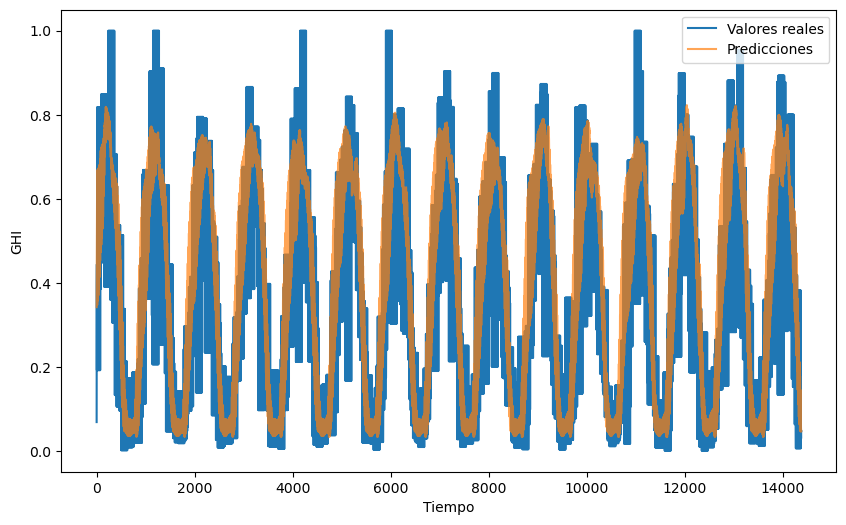

In [51]:


# Probar el modelo
# Preparar el conjunto de prueba (días nubosos)
fecha_inicio_prueba = '2023-03-1 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-15 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test,hour_sin_train,hour_cos_train,fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps 
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed.flatten(), label='Valores reales')
plt.plot(y_pred_inversed.flatten(), label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()


plt.show()

R² del modelo en el conjunto de prueba: 0.539


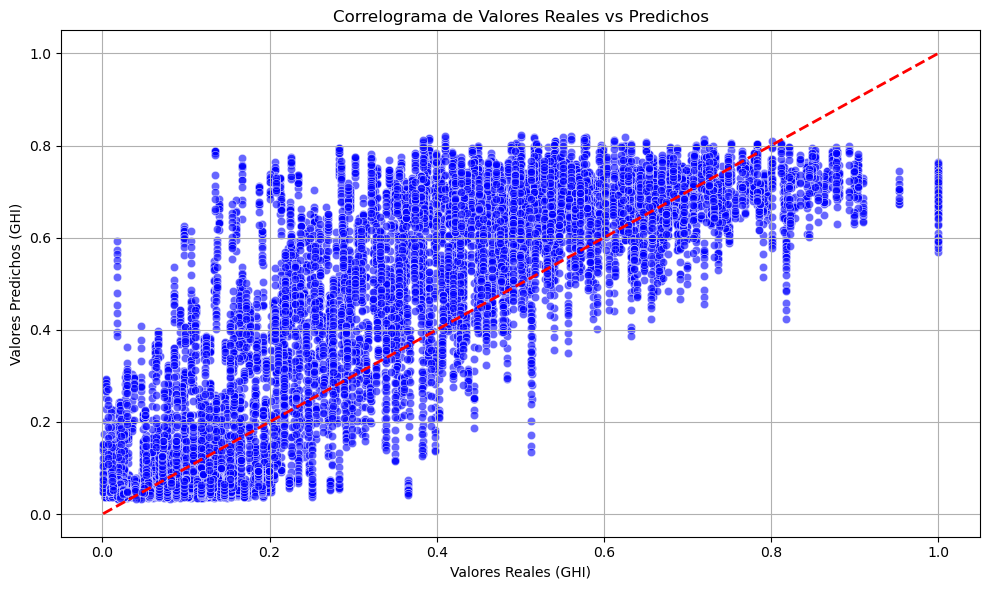

Step 1: MAE = 0.108, RMSE = 0.144
Step 2: MAE = 0.112, RMSE = 0.149
Step 3: MAE = 0.114, RMSE = 0.153
Step 4: MAE = 0.117, RMSE = 0.157
Step 5: MAE = 0.117, RMSE = 0.157
Step 6: MAE = 0.119, RMSE = 0.160
Step 7: MAE = 0.125, RMSE = 0.168
Step 8: MAE = 0.127, RMSE = 0.171
Step 9: MAE = 0.128, RMSE = 0.171
Step 10: MAE = 0.129, RMSE = 0.173
Step 11: MAE = 0.130, RMSE = 0.173
Step 12: MAE = 0.137, RMSE = 0.182


In [52]:
import seaborn as sns
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R^2 para evaluar el ajuste de las predicciones
r2 = r2_score(y_test_seq_inversed.flatten(), y_pred_inversed.flatten())
print(f'R² del modelo en el conjunto de prueba: {r2:.3f}')

# Crear un correlograma (scatter plot) de los valores predichos vs los valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_seq_inversed.flatten(), y=y_pred_inversed.flatten(), alpha=0.6, color='b')
plt.xlabel('Valores Reales (GHI)')
plt.ylabel('Valores Predichos (GHI)')
plt.title('Correlograma de Valores Reales vs Predichos')
plt.plot([y_test_seq_inversed.min(), y_test_seq_inversed.max()],
         [y_test_seq_inversed.min(), y_test_seq_inversed.max()],
         color='red', linestyle='--', linewidth=2)  # Línea de referencia y=x
plt.grid(True)
plt.tight_layout()
plt.show()

for step in range(12):
    mae = mean_absolute_error(y_test_seq_inversed[:, step], y_pred_inversed[:, step])
    rmse = np.sqrt(mean_squared_error(y_test_seq_inversed[:, step], y_pred_inversed[:, step]))
    print(f'Step {step + 1}: MAE = {mae:.3f}, RMSE = {rmse:.3f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


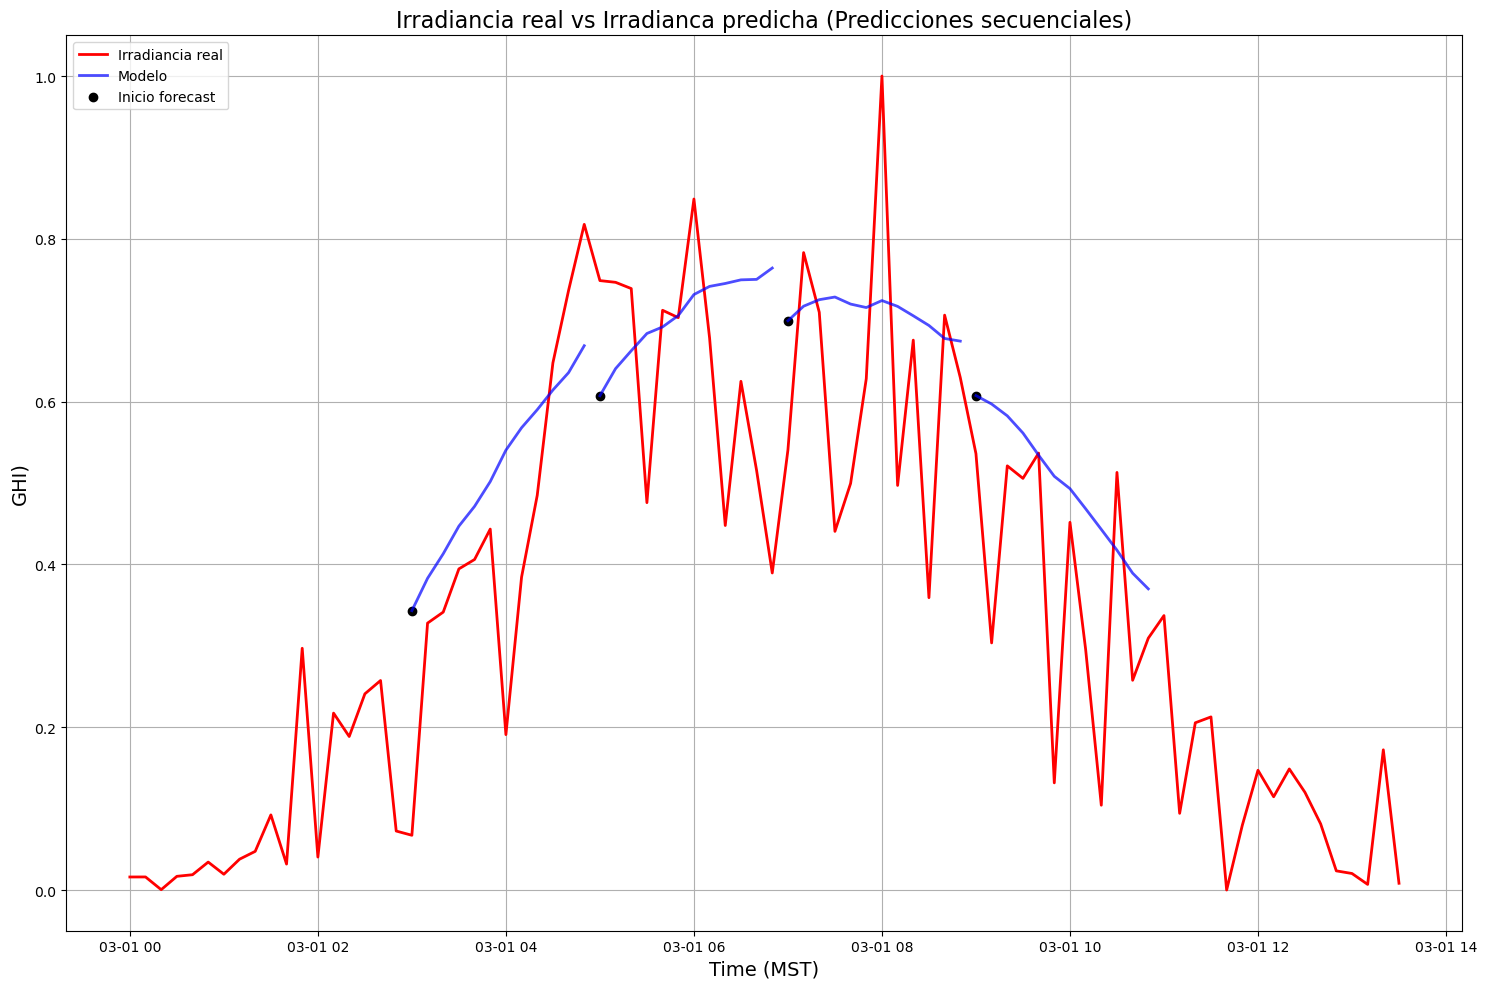

In [36]:
# Probar el modelo - Predicciones a lo largo de un día completo
fecha_inicio_prueba = '2023-03-01 00:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-01 23:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train, hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test, hour_sin_train, hour_cos_train, fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps (para tener predicciones a lo largo de todo el día)
time_steps = 18
n_steps = 12
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps, n_steps)

# Hacer predicciones para todas las secuencias del día
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)
y_pred_inversed = scaler_test.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)



import matplotlib.dates as mdates

# Graficar el comportamiento diario - Real versus Predicción con intervalos secuenciales
plt.figure(figsize=(15, 10))

# Definir etiquetas de tiempo para el eje X
horas = pd.date_range(start=fecha_inicio_prueba, periods=len(y_ghi_test), freq='10min')

# Graficar valores reales de irradiancia
plt.plot(horas, y_ghi_test, color='red', label='Irradiancia real', linewidth=2)

# Graficar predicciones a lo largo del día, donde cada nueva predicción empieza después de la anterior
for i in range(0, len(y_pred_inversed), n_steps):
    if i + n_steps > len(y_pred_inversed):
        break

    # Extraer la secuencia de horas para la predicción actual
    pred_horas = horas[i + time_steps: i + time_steps + n_steps]

    # Graficar la predicción actual
    plt.plot(pred_horas, y_pred_inversed[i], color='blue', alpha=0.7, label='Modelo' if i == 0 else "", linewidth=2)

    # Marcar solo el primer punto de la predicción con un punto negro (inicio de la predicción)
    plt.scatter(pred_horas[0], y_pred_inversed[i][0], color='black', marker='o', label='Inicio forecast' if i == 0 else "")


# Añadir leyenda y títulos para mayor claridad
plt.xlabel('Time (MST)', fontsize=14)
plt.ylabel('GHI)', fontsize=14)
plt.title('Irradiancia real vs Irradianca predicha (Predicciones secuenciales)', fontsize=16)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()



Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la úl

[ WARN:0@16564.231] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.234] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.235] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.235] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.236] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.237] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.238] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.239] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16564.239] global loadsave.cpp:241 findDecoder imread_(

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


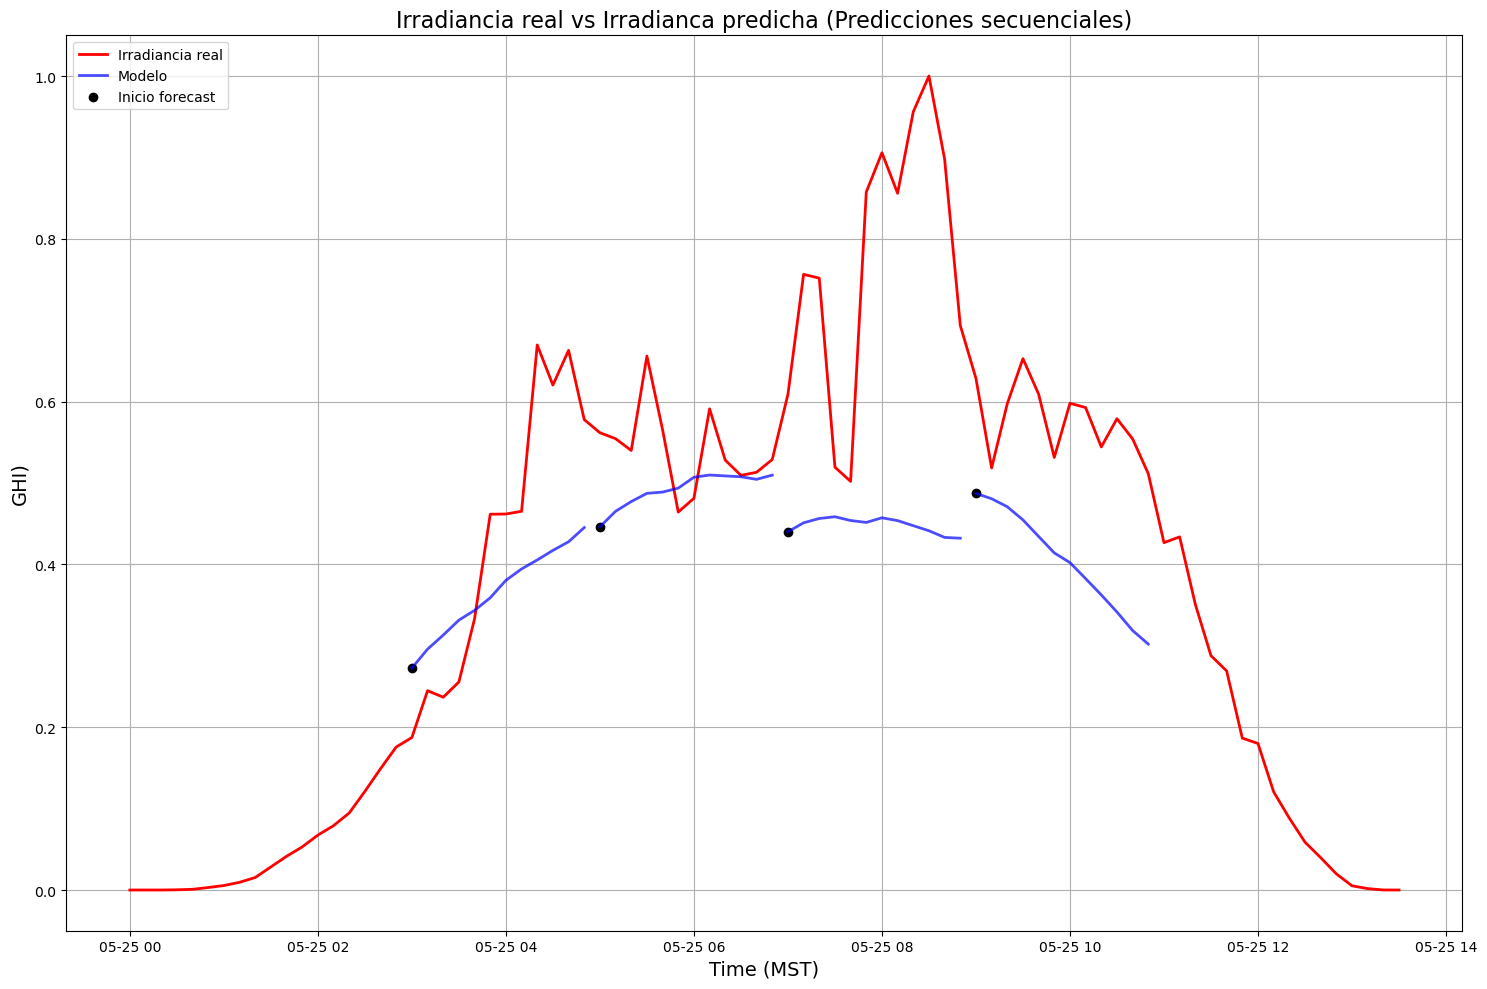

In [50]:

# Probar el modelo - Predicciones a lo largo de un día completo
fecha_inicio_prueba = '2023-05-25 00:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-05-25 23:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train, hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test, hour_sin_train, hour_cos_train, fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps (para tener predicciones a lo largo de todo el día)
time_steps = 18
n_steps = 12
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps, n_steps)

# Hacer predicciones para todas las secuencias del día
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)
y_pred_inversed = scaler_test.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)



import matplotlib.dates as mdates

# Graficar el comportamiento diario - Real versus Predicción con intervalos secuenciales
plt.figure(figsize=(15, 10))

# Definir etiquetas de tiempo para el eje X
horas = pd.date_range(start=fecha_inicio_prueba, periods=len(y_ghi_test), freq='10min')

# Graficar valores reales de irradiancia
plt.plot(horas, y_ghi_test, color='red', label='Irradiancia real', linewidth=2)

# Graficar predicciones a lo largo del día, donde cada nueva predicción empieza después de la anterior
for i in range(0, len(y_pred_inversed), n_steps):
    if i + n_steps > len(y_pred_inversed):
        break

    # Extraer la secuencia de horas para la predicción actual
    pred_horas = horas[i + time_steps: i + time_steps + n_steps]

    # Graficar la predicción actual
    plt.plot(pred_horas, y_pred_inversed[i], color='blue', alpha=0.7, label='Modelo' if i == 0 else "", linewidth=2)

    # Marcar solo el primer punto de la predicción con un punto negro (inicio de la predicción)
    plt.scatter(pred_horas[0], y_pred_inversed[i][0], color='black', marker='o', label='Inicio forecast' if i == 0 else "")


# Añadir leyenda y títulos para mayor claridad
plt.xlabel('Time (MST)', fontsize=14)
plt.ylabel('GHI)', fontsize=14)
plt.title('Irradiancia real vs Irradianca predicha (Predicciones secuenciales)', fontsize=16)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

